In [1]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [141]:
dataset = []
for path in os.listdir('./Dataset/'):
    image = nib.load('./Dataset/'+path)
    
    dataset.append(np.array(image.get_fdata())[:,:,:,0]/np.array(image.get_fdata())[:,:,:,0].max())
dataset = np.array(dataset)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


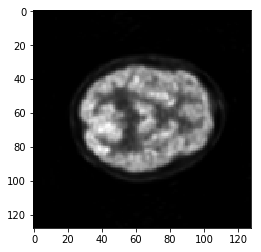

In [142]:
plt.imshow(dataset[0][:,:,32],cmap='gray')
plt.show()

In [4]:
def gridInterval(img,k):
    #Number of Pixels
    N = img.shape[0]*img.shape[1]*img.shape[2]
    #Average Area of the Supervoxels
    ratio = N/k
    #Distance between centers
    S = (ratio)**(1/3)
    
    return int(S)

In [5]:
class SuperVoxel():
    '''Class to represent a supervoxel'''
    def __init__(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))
        self.voxels = []
        
    def update(self,intensity,x,y,z):
        self.i = intensity
        self.x = x
        self.y = y
        self.z = z
        self.coord = np.array((x,y,z))
        
    def describe(self):
        print("Coordinates: ",self.coord," Intensity: ",self.i, " Voxel Count: ",len(self.voxels))
      
        
def createSuperVoxel(x,y,z,image):
    '''Function to return a SuperVoxel object'''
    return SuperVoxel(image[x,y,z],x,y,z)

def updateSuperVoxel(voxel,x,y,z,image):
    '''Function to return a SuperVoxel object'''
    return voxel.update(image[x,y,z],x,y,z)



In [6]:
def calculateVoxelDistance(voxel,i,x,y,z,S,l):
    #calculating D_ij(in)
    d_in = math.sqrt((voxel.i - i)**2)
    
    #Calculating D_ij(sp)
    d_sp = np.linalg.norm(voxel.coord - np.array((x,y,z)))
    
    #Calculating final distance
    D = math.sqrt(
        
        (d_in/l)**2 + (d_sp/S)**2
        
    )
    
    return D

In [7]:
# To define the initial cluster centers distanced at S
def initialClusterCenter(S,img,img_h,img_w,img_d,clusters):
    h = S // 3
    w = S // 3
    d = S // 3
    while h < img_h:
        while w < img_w:
            while d < img_d:
                clusters.append(createSuperVoxel(int(h), int(w), int(d), img))
                d += S
            d = S // 3
            w += S
        w = S // 3
        h += S
    
    #Returning clusters
    return clusters

In [8]:
def getGradient(h,w,d,img_h,img_w,img_d,img):
    
    #Checking for out of bounds
    if w+1 >= img_w:
        w = img_w -2
    if h+1 >= img_h:
        h = img_h -2
    if d+1 >= img_d:
        d = img_d -2
    
    #Using sq-gradient formula
    gradient = (img[h+1,w,d] - img[h-1,w,d])**2 + (img[h,w+1,d] - img[h,w-1,d])**2 + (img[h,w,d+1] - img[h,w,d-1])**2
    
    #returning value
    return gradient


def reassignwGradient(clusters,img):
    #count = 0
    for c in clusters:
        #count += 1
        c_gradient = getGradient(c.x,c.y,c.z,img.shape[0],img.shape[1],img.shape[2],img)
        
        for dh in range(-1,2):
            for dw in range(-1,2):
                for dd in range(-1,2):
                    H = c.x + dh
                    W = c.y + dw
                    D = c.z + dd
                    
                    n_gradient = getGradient(H,W,D,img.shape[0],img.shape[1],img.shape[2],img)
                    
                    if n_gradient < c_gradient:
                        #Update to the smaller gradient voxel
                        #print("On cent",count,"Reassigned",c.x,c.y,c.z,"to",H,W,D)
                        
                        updateSuperVoxel(c,H,W,D,img)
                        c_gradient = n_gradient
                        

                        
    
    

In [9]:
def assignVoxels(clusters,S,l,img,tag,dis):
    '''
    To assign cluster voxels to the centroids
    '''
    
    #Taking the image coordinates
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_d = img.shape[2]
    
    for c in tqdm(clusters):
        
        for h in range(c.x- 2*S, c.x + 2*S):
            if h < 0 or h >= img_h: continue
                
            for w in range(c.y - 2*S, c.y + 2*S):
                if w < 0 or w >= img_w:continue
                    
                for d in range(c.z - 2*S, c.z + 2*S ):
                    if d<0 or d >= img_d:continue
                        
                    #Getting the intensity    
                    intensity = img [h,w,d]
                    
                    #Calculating the similarity score
                    distance = calculateVoxelDistance(c, intensity, h,w,d, S,l)
                    
                    #Reassignment
                    if distance < dis[h,w,d]:
                        if (h,w,d) not in tag:
                            tag[(h,w,d)] = c
                            c.voxels.append((h,w,d))
                            
                        else:
                            tag[(h,w,d)].voxels.remove((h,w,d))
                            tag[(h,w,d)] = c
                            c.voxels.append((h,w,d))
                            
                        dis[h,w] = distance

In [10]:
def updateCentroids(clusters,img):
    for c in clusters:
        sum_h = sum_w = sum_d = number = 0
        for p in c.voxels:
            #Sum of values
            sum_h += p[0]
            sum_w += p[1]
            sum_d += p[2]
            number += 1
            
            
            #Taking the mean
            H = sum_h // number
            W = sum_w // number
            D = sum_d // number
            
            #Updating voxel
            updateSuperVoxel(c,H,W,D,img)

In [11]:
def runSlic(img,k,l):
    
    #Initialing arguments
    S = gridInterval(img,k)
    img_h = img.shape[0]
    img_w = img.shape[1]
    img_d = img.shape[2]
    
    #History 
    tag = dict()
    dis = np.full((img_h, img_w, img_d), np.inf)
    
    #Initializing centroids
    clusters = initialClusterCenter(S,img,img_h,img_w,img_d,[])
    reassignwGradient(clusters,img)
    

    for i in range(10):
        try:
            #Reassignment
            print("On iteraion %d\n"%(i+1))
            assignVoxels(clusters,S,l,img,tag,dis)

            updateCentroids(clusters,img)

            print("\n\n")
        except:
            print("Loop Broken")
            break

        
    return clusters,tag,dis

In [132]:
def imageCovert(img,clusters):
    image = img.copy()
    for c in clusters:
        for x,y,z in c.voxels:
            image[x,y,z]=c.i
    return image
                

In [ ]:
clusters,tag,dis = runSlic(test,10,2)


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

On iteraion 1




 22%|██████████████████▍                                                                | 4/18 [03:14<10:02, 43.06s/it]

In [18]:
for c in clusters:
    c.describe()

Coordinates:  [30 32 10]  Intensity:  120.0  Voxel Count:  16956
Coordinates:  [11 16 45]  Intensity:  3.0  Voxel Count:  1026
Coordinates:  [39 79 17]  Intensity:  6715.0  Voxel Count:  12435
Coordinates:  [59 72 34]  Intensity:  6164.0  Voxel Count:  5379
Coordinates:  [18 90  4]  Intensity:  0.0  Voxel Count:  5468
Coordinates:  [24 75 44]  Intensity:  0.0  Voxel Count:  3954
Coordinates:  [ 17 114   5]  Intensity:  1.0  Voxel Count:  8732
Coordinates:  [  8 102  40]  Intensity:  0.0  Voxel Count:  2386
Coordinates:  [62 27  9]  Intensity:  404.0  Voxel Count:  9065
Coordinates:  [90 22 35]  Intensity:  0.0  Voxel Count:  16701
Coordinates:  [73 76 15]  Intensity:  7730.0  Voxel Count:  4270
Coordinates:  [64 63 32]  Intensity:  13614.0  Voxel Count:  844
Coordinates:  [75 78 24]  Intensity:  10786.0  Voxel Count:  1361
Coordinates:  [63 65 34]  Intensity:  11099.0  Voxel Count:  481
Coordinates:  [ 92 101  20]  Intensity:  1.0  Voxel Count:  4809
Coordinates:  [ 74 114  28]  Intens

In [143]:
test = dataset[0].copy()

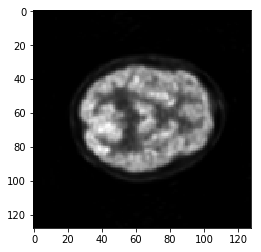

In [137]:
plt.imshow(test[:,:,32],cmap='gray')
plt.show()

In [133]:
converted = imageCovert(test,clusters)

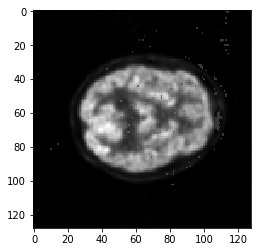

In [138]:
plt.imshow(converted[:,:,32],cmap='gray')
plt.show()

In [139]:
(test-converted).sum()

-115275322.0

In [127]:
clusters[3].i

6164.0

In [123]:
clusters[3].coord

array([59, 72, 34])

In [124]:
clusters[3].voxels

[(0, 94, 37),
 (0, 113, 12),
 (0, 113, 13),
 (0, 113, 14),
 (0, 113, 15),
 (0, 113, 16),
 (0, 113, 17),
 (0, 113, 18),
 (0, 113, 19),
 (0, 113, 20),
 (0, 113, 21),
 (0, 113, 22),
 (0, 113, 23),
 (0, 113, 24),
 (0, 113, 25),
 (0, 113, 26),
 (0, 113, 27),
 (0, 113, 28),
 (0, 113, 29),
 (0, 113, 30),
 (0, 113, 31),
 (0, 113, 32),
 (0, 113, 33),
 (0, 113, 34),
 (0, 113, 35),
 (0, 113, 36),
 (0, 113, 37),
 (0, 114, 12),
 (0, 114, 13),
 (0, 114, 14),
 (0, 114, 15),
 (0, 114, 16),
 (0, 114, 17),
 (0, 114, 18),
 (0, 114, 19),
 (0, 114, 20),
 (0, 114, 21),
 (0, 114, 22),
 (0, 114, 23),
 (0, 114, 24),
 (0, 114, 25),
 (0, 114, 26),
 (0, 114, 27),
 (0, 114, 28),
 (0, 114, 29),
 (0, 114, 30),
 (0, 114, 31),
 (0, 114, 32),
 (0, 114, 33),
 (0, 114, 34),
 (0, 114, 35),
 (0, 114, 36),
 (0, 114, 37),
 (1, 99, 40),
 (1, 113, 25),
 (1, 113, 37),
 (1, 113, 59),
 (1, 114, 12),
 (1, 114, 13),
 (1, 114, 14),
 (1, 114, 15),
 (1, 114, 16),
 (1, 114, 17),
 (1, 114, 18),
 (1, 114, 19),
 (1, 114, 20),
 (1, 114, 21

In [125]:
converted[34,101,59]

45.0

In [126]:
test[34,101,59]

45.0

In [64]:
for i in converted[:,:,50]:
    print(i)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   1.   0.   0.   0.   0.   3.  41. 235. 229. 120.
  56. 177. 580. 380. 248. 407. 412. 144.  28.  45.  80.  31.   6.   1.
   0.   1.   6.  32.  88. 134. 165. 188. 108.  36.   4.   1.   1.   7.
  33.  44.  41.  70. 140. 103.  42.  16.  27.  58.  85. 524. 976. 473.
 105.  50. 357. 599. 143.  20.   1.   0.   0.   0.   0.   3.  25. 164.
 454. 228.  56.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   1.   1.   0.   0.   0.   1.  17.  97. 330. 250. 113.
 113. 283. 613. 402. 308. 507. 536. 398. 313. 216.  96.  35.  27.  18.
  12.  23.  53.  44.  83. 120. 129. 122.  65.  41.  42.  39.   7.